In [3]:
import pandas as pd

df_bss = pd.read_csv('C:/My_Projects/churn-prediction-mlops-pipeline/data/raw-data/bss_data.csv')
df_complaints = pd.read_csv('C:/My_Projects/churn-prediction-mlops-pipeline/data/raw-data/complaints_data.csv')
df_network = pd.read_csv('C:/My_Projects/churn-prediction-mlops-pipeline/data/raw-data/network_data.csv')

In [4]:
print(df_bss.shape)
print(df_bss.info())

print(df_complaints.shape)
print(df_complaints.info())

print(df_network.shape)
print(df_network.info())


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

In [5]:
print(df_bss.isnull().sum())
print(df_complaints.isnull().sum())
print(df_network.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Unnamed: 0      0
complaint_id    0
customerID      0
date            0
issue           0
status          0
dtype: int64
date               0
customerID         0
total_calls        0
dropped_calls      0
data_volume_MB     0
throughput_Mbps    0
dtype: int64


In [6]:
print(df_bss['Churn'].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [12]:
# Convert 'date' to datetime in complaints_df and network_df
df_complaints['date'] = pd.to_datetime(df_complaints['date'])
df_network['date'] = pd.to_datetime(df_complaints['date'])

In [13]:
# Total complaints per customer
complaint_summary = df_complaints.groupby('customerID').agg(
    complaints_count=('complaint_id', 'count'),
    unresolved_complaints=('status', lambda x: (x != 'Resolved').sum())
).reset_index()

In [17]:
import pandas as pd

# Read the data
network_df = pd.read_csv("data/raw-data/network_data.csv")

# Replace zeros in total_calls with NaN to avoid division errors, then fill with 0
network_df["call_drop_rate"] = network_df["dropped_calls"] / network_df["total_calls"].replace(0, pd.NA)
network_df["call_drop_rate"] = network_df["call_drop_rate"].fillna(0)

# Convert data volume to GB
network_df["data_usage_gb"] = network_df["data_volume_MB"] / 1024

# Group by customerID
network_agg = network_df.groupby("customerID").agg({
    "call_drop_rate": "mean",
    "data_usage_gb": "sum",
    "throughput_Mbps": "mean"
}).reset_index()

# Preview
print(network_agg.head())


   customerID  call_drop_rate  data_usage_gb  throughput_Mbps
0  0002-ORFBO        0.033369      10.107227        31.052500
1  0003-MKNFE        0.051590      10.233760        28.905000
2  0004-TLHLJ        0.028409      11.058779        28.447500
3  0011-IGKFF        0.029386       9.110850        32.543333
4  0013-EXCHZ        0.006944       9.173701        30.853333


In [18]:
import pandas as pd

# Read complaints data
complaints_df = pd.read_csv("data/raw-data/complaints_data.csv")

# Total complaints per customer
total_complaints = complaints_df.groupby("customerID").size().reset_index(name="total_complaints")

# Resolved complaints
resolved = complaints_df[complaints_df["status"] == "Resolved"].groupby("customerID").size().reset_index(name="resolved_complaints")

# Unresolved complaints
unresolved = complaints_df[complaints_df["status"] != "Resolved"].groupby("customerID").size().reset_index(name="unresolved_complaints")

# Merge all into one
complaints_agg = total_complaints.merge(resolved, on="customerID", how="left") \
                                 .merge(unresolved, on="customerID", how="left")

# Fill NaNs with 0
complaints_agg.fillna(0, inplace=True)

# Preview
print(complaints_agg.head())


   customerID  total_complaints  resolved_complaints  unresolved_complaints
0  0002-ORFBO                 8                  5.0                    3.0
1  0003-MKNFE                11                  2.0                    9.0
2  0004-TLHLJ                 5                  1.0                    4.0
3  0011-IGKFF                12                  3.0                    9.0
4  0013-EXCHZ                11                  0.0                   11.0


In [22]:
# Merge BSS and Network Data
df_merged = df_bss.merge(network_agg, on='customerID', how='left')

# Merge with Complaint Aggregations
df_merged = df_merged.merge(complaints_agg, on='customerID', how='left')

# Fill missing values only for available columns
cols_to_fill = ['call_drop_rate', 'data_usage_gb', 'total_complaints', 
                'resolved_complaints', 'unresolved_complaints']

# Fill NaNs with 0
df_merged[cols_to_fill] = df_merged[cols_to_fill].fillna(0)

# Quick check
print(df_merged.shape)
print(df_merged.head())


(7043, 27)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ...  \
0  No phone service             DSL             No  ...   
1                No             DSL            Yes  ...   
2                No             DSL            Yes  ...   
3  No phone service             DSL            Yes  ...   
4                No     Fiber optic             No  ...   

               PaymentMethod MonthlyCharges TotalCharges Churn call_drop_rate  \
0           Electronic check          29.85        29.85    No       0.0

In [23]:
df_merged.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaymentMethod,MonthlyCharges,TotalCharges,Churn,call_drop_rate,data_usage_gb,throughput_Mbps,total_complaints,resolved_complaints,unresolved_complaints
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,Electronic check,29.85,29.85,No,0.062500,9.623506,27.535000,13,5.0,8.0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Mailed check,56.95,1889.5,No,0.021296,7.744688,26.696667,8,2.0,6.0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,Mailed check,53.85,108.15,Yes,0.016369,9.575225,26.060000,8,2.0,6.0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Bank transfer (automatic),42.30,1840.75,No,0.028629,8.006885,19.790000,15,4.0,11.0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,Electronic check,70.70,151.65,Yes,0.027083,9.155674,28.206667,19,6.0,13.0


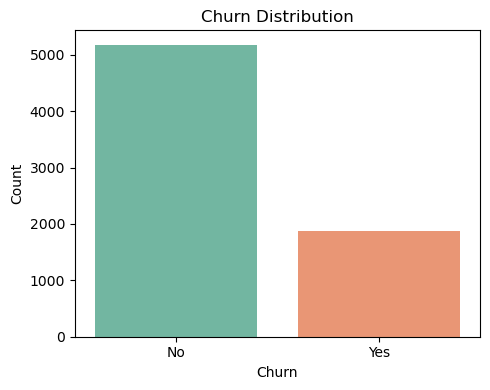

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot churn distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=df_merged, x='Churn', palette='Set2')
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


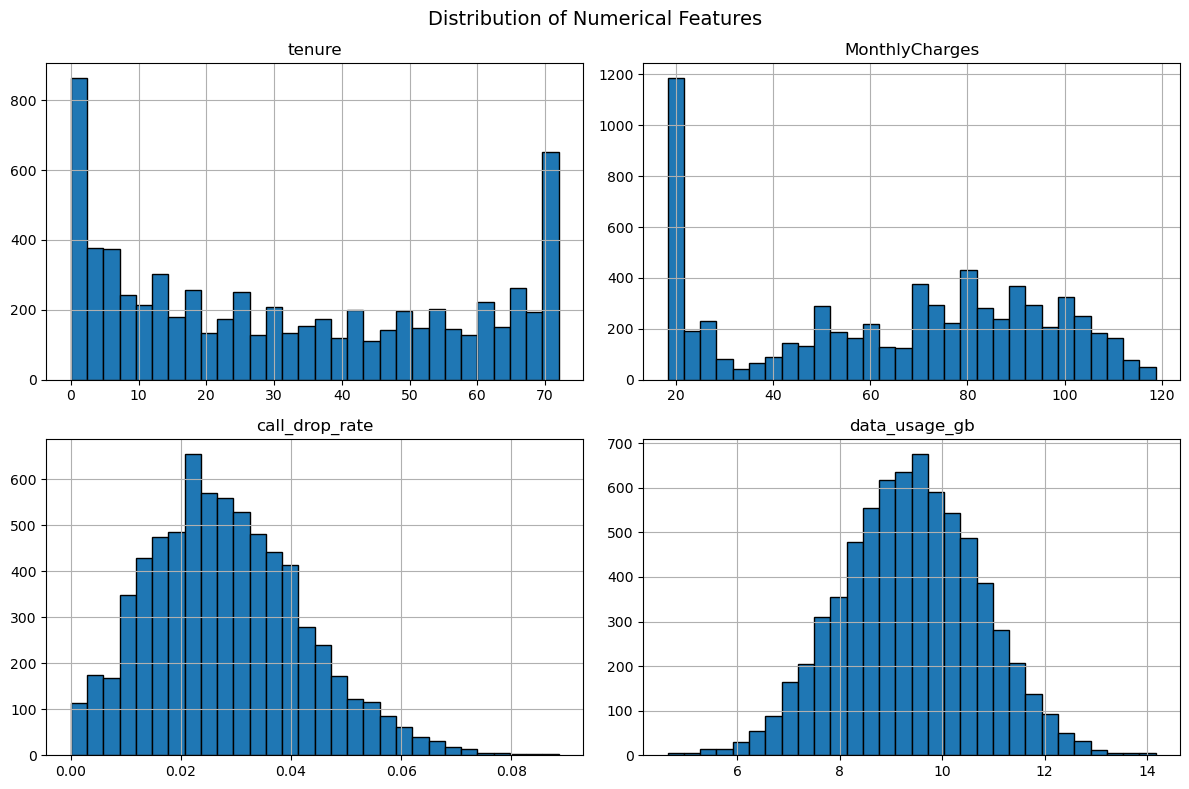

In [25]:
# Histograms for selected features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'call_drop_rate', 'data_usage_gb']

df_merged[numeric_cols].hist(bins=30, figsize=(12, 8), edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()


In [28]:
df_merged.to_csv("C:/My_Projects/df_merged.csv", index=False)

In [46]:
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')

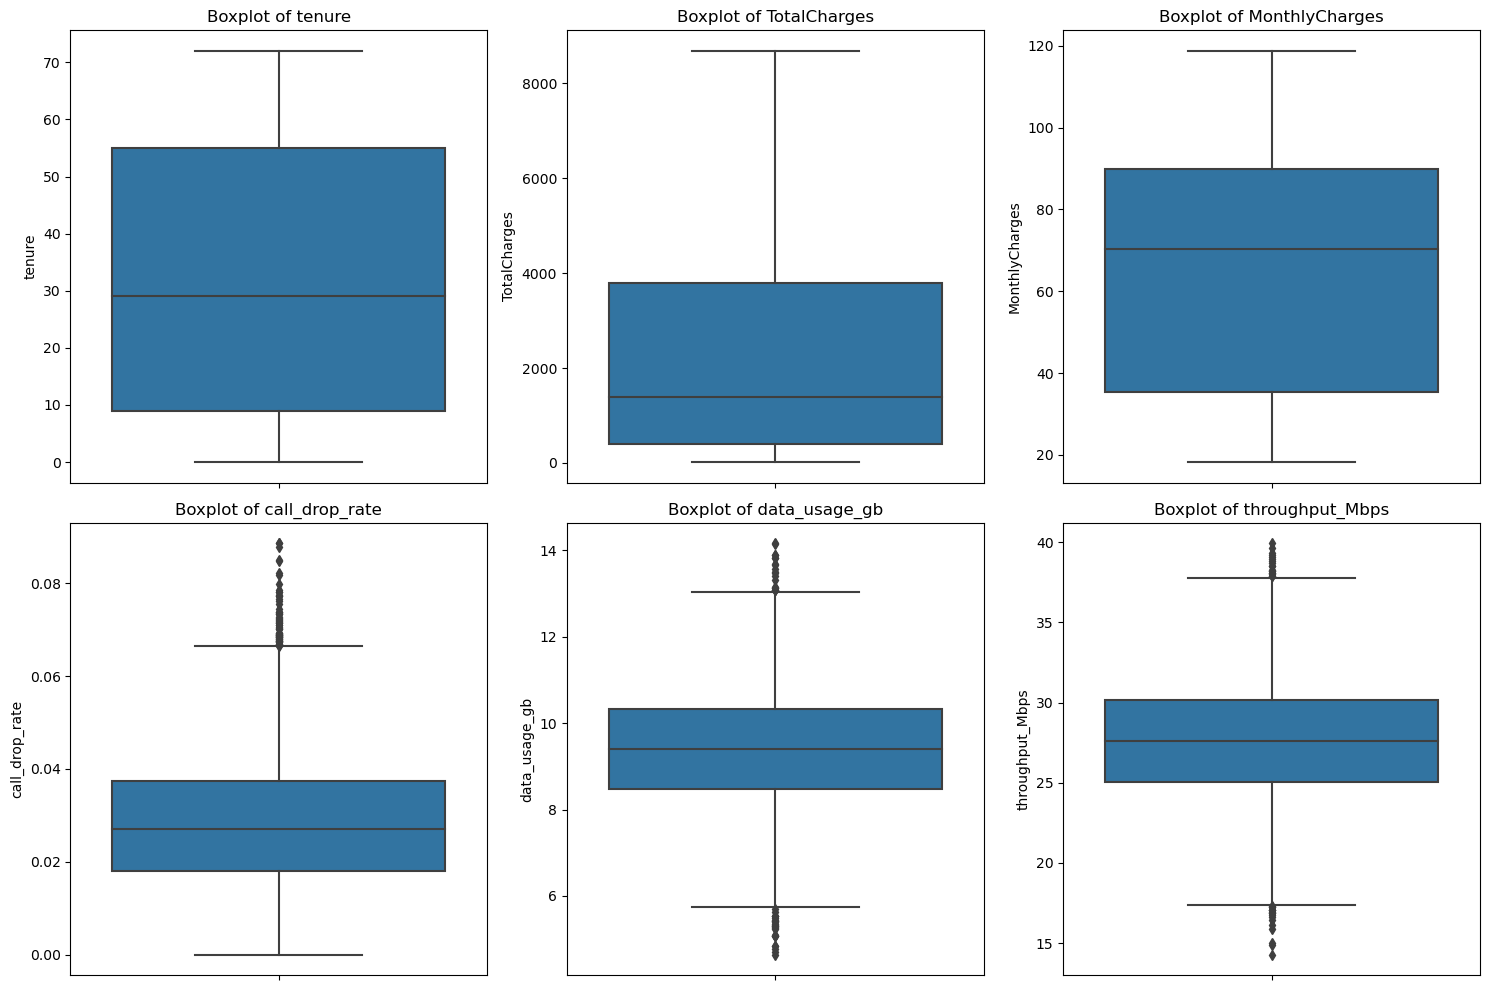

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplots to detect outliers in numerical features
numeric_cols = ['tenure', 'TotalCharges', 'MonthlyCharges', 'call_drop_rate', 'data_usage_gb', 'throughput_Mbps']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=col, data=df_merged)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [34]:
df_merged['Churn_Label'] = df_merged['Churn'].map({'Yes': 1, 'No': 0})

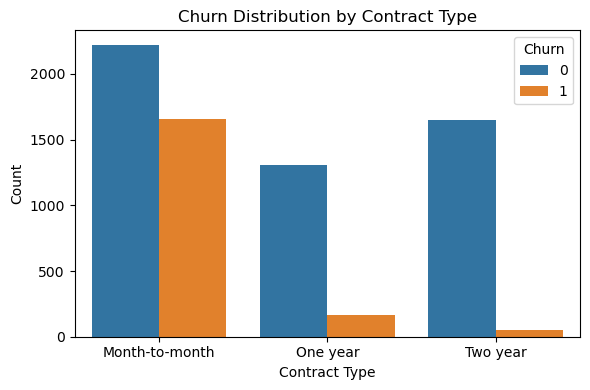

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df_merged, x='Contract', hue='Churn_Label')
plt.title('Churn Distribution by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


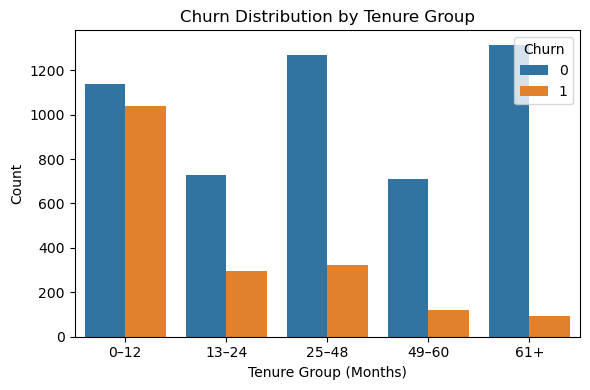

In [37]:
df_merged['tenure_group'] = pd.cut(df_merged['tenure'],
                                   bins=[0, 12, 24, 48, 60, df_merged['tenure'].max()],
                                   labels=['0–12', '13–24', '25–48', '49–60', '61+'])

plt.figure(figsize=(6,4))
sns.countplot(data=df_merged, x='tenure_group', hue='Churn_Label')
plt.title('Churn Distribution by Tenure Group')
plt.xlabel('Tenure Group (Months)')
plt.ylabel('Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


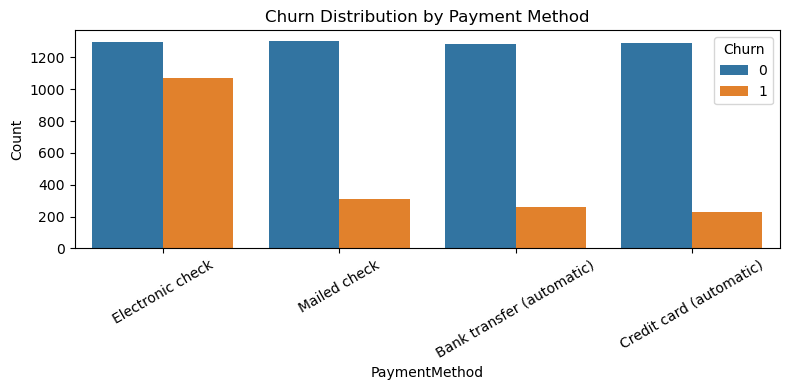

In [38]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_merged, x='PaymentMethod', hue='Churn_Label')
plt.title('Churn Distribution by Payment Method')
plt.xticks(rotation=30)
plt.ylabel('Count')
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


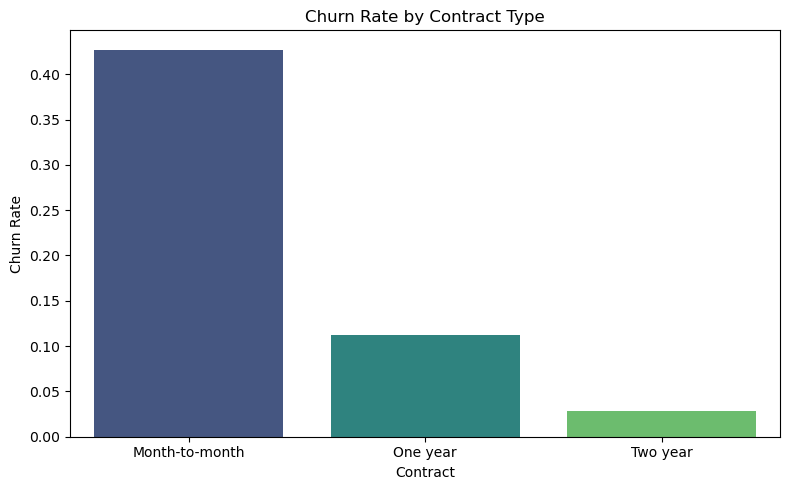

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate churn rate by contract type
contract_churn = df_merged.groupby("Contract")["Churn_Label"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="Contract", y="Churn_Label", data=contract_churn, palette="viridis")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Contract Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


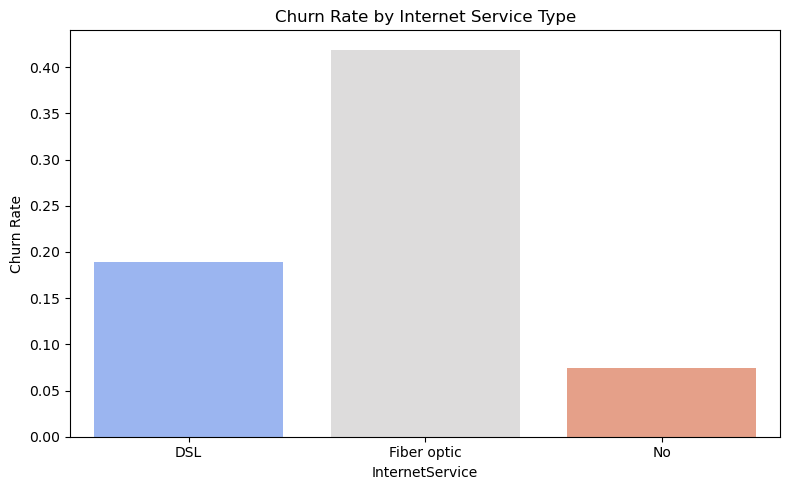

In [40]:
# Group and calculate churn rate per internet service type
internet_churn = df_merged.groupby("InternetService")["Churn_Label"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="InternetService", y="Churn_Label", data=internet_churn, palette="coolwarm")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Internet Service Type")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


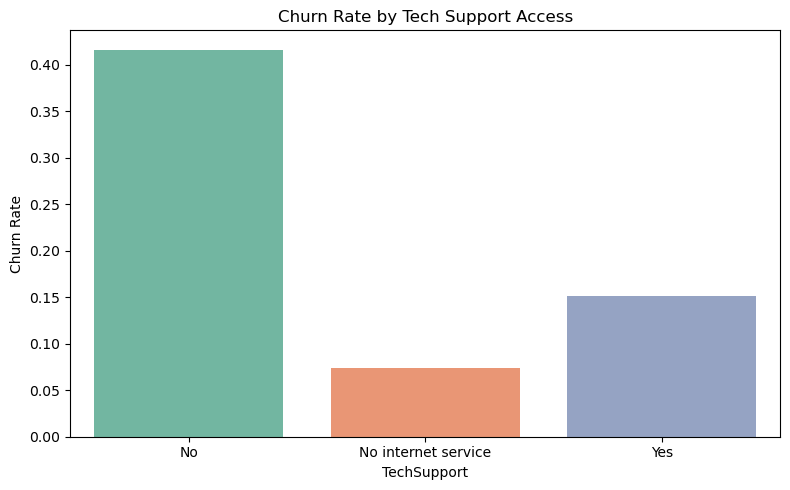

In [42]:
# Churn rate by TechSupport
tech_support_churn = df_merged.groupby("TechSupport")["Churn_Label"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x="TechSupport", y="Churn_Label", data=tech_support_churn, palette="Set2")
plt.ylabel("Churn Rate")
plt.title("Churn Rate by Tech Support Access")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


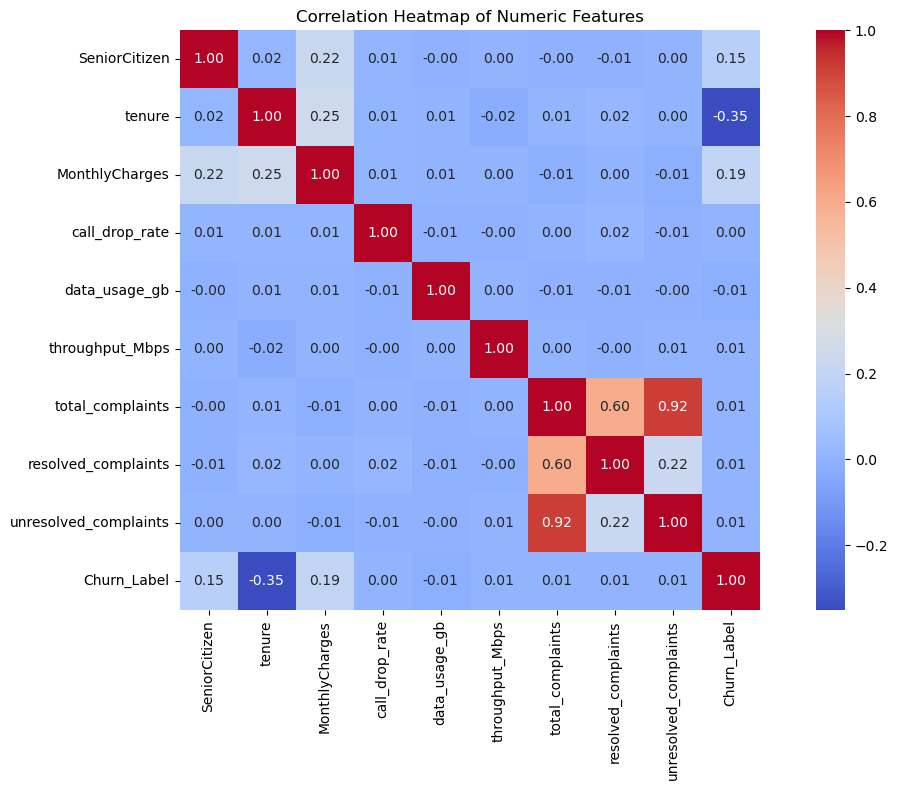

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_cols = df_merged.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


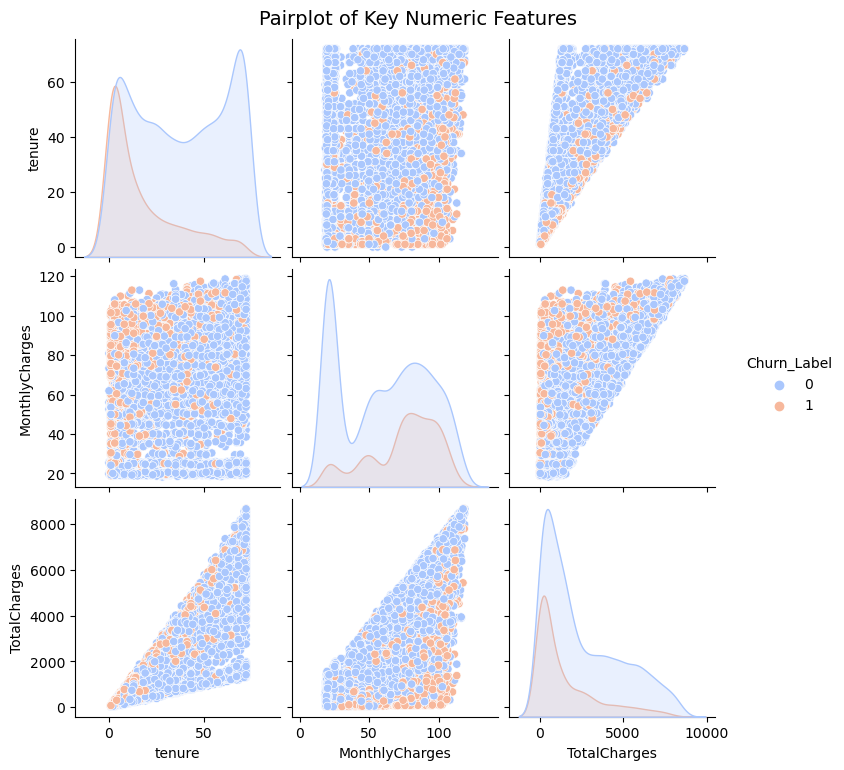

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy to avoid warnings
df_plot = df_merged.copy()

# Map churn labels if not done already
df_plot['Churn_Label'] = df_plot['Churn'].map({'Yes': 1, 'No': 0})

# Select key numerical features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Plot pairplot with hue based on Churn_Label
sns.pairplot(df_plot[numeric_cols + ['Churn_Label']], hue='Churn_Label', palette='coolwarm')
plt.suptitle("Pairplot of Key Numeric Features", fontsize=14, y=1.02)
plt.show()


In [ ]:
g